# Trace Estimator  
https://doi.org/10.1016/0377-0427(96)00018-0 
## b) Algorithm 1 with Gauss-Radau quadrature

In [1]:
import numpy as np 
from math import fabs
import matplotlib.pyplot as plt
from warnings import warn
#for part e)
from matrices import heat_flow_function, Pei_function, VFH_function, Poisson_function, wathen_ge, Lehmer_function 
import time 
from scipy.linalg import block_diag

n_A = 5
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

vec1 = -1*np.ones(n_A-1)
vec2 = 2*np.ones(n_A)
vec3 = -1*np.ones(n_A-1)
A = tridiag(vec1, vec2, vec3)
A



array([[ 2., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.],
       [ 0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1.,  2.]])

In [87]:
def T_tilda(T, gamma, a):
    """
    Implements the correction mentioned in Remark 3. 
    INPUT:
    - T: T_j
    - gamma: gamma_j
    - a: scalar, a or b
    OUTPUT:
    - T_tilda_j: matrix as defined page 76 of Bai et al., for the Gauss-Radau case.
    """
    e_j = np.zeros(T.shape[0])
    e_j[-1] = 1
    delta = np.linalg.solve(T-a*np.eye(T.shape[0]), gamma*gamma*e_j) # tridiagonal system, could be written without np.linalg.solve maybe
    phi = a + delta[-1]
    temp_left = np.vstack((T, gamma*e_j))
    temp_right = np.expand_dims(np.append(gamma*e_j, phi),1)
    return np.hstack((temp_left, temp_right))

def Gerschgorin(A):
    """Simple way to find a and b in R such that the eigenvalues of A are in [a,b].
    INPUT:
    - square matrix A
    OUTPUT:
    - array: [a,b]
    """
    for i in range(A.shape[0]):
        r = 0
        pivot = A[i,i]
        for j in range(A.shape[1]):
            if i!=j:
                r += fabs(A[i][j])

        if i==0:
            a = pivot-r
            b = pivot+r
        else:
            if (pivot-r)<a:
                a = pivot-r
            if (pivot+r)>b:
                b = pivot+r

    return np.array([a, b])    


def check_new_eig(a, eigs, tol=1e-12):
    """
    Checks if a is in array eigs.
    INPUT: 
    - a: number
    - eigs: eigenvalues
    - tol: tolerance 
    OUTPUT:
    - bool: true if a is in eigs, else false.
    """
    for i in range(len(eigs)):
        if np.abs(a-eigs[i])<tol:
            return True
    return False

        
def check_ortho(X, tol=1e-8):
    """
    Checks if the columns of X are orthogonal to one another.
    INPUT:
    - X: 2d matrix, its columns are the ones we want to check the orthogonality of
    OUTPUT:
    - bool: 
        - True: the vectors are orthogonal
        - False: they are not.
    """
    prod = X.T @ X
    for i in range(prod.shape[0]):
        for j in range(prod.shape[1]):
            if i==j:
                if np.abs(prod[i,j]-1)>tol:
                    return False
            else:
                if np.abs(prod[i,j])>tol:
                    return False
    return True


In [88]:
# check new eig
eigs = [  6.47720775, 123.52279225, 125.        ]
a = 125
check_new_eig(a=a, eigs= eigs)

True

In [89]:
# test check ortho function
if not check_ortho(np.eye(10)):
    print("ERROR in check ortho.")

A = np.array([[1, 0, 0], [0, 1, 1]/np.sqrt(2), [0, 1, -1]/np.sqrt(2)]).T
if not check_ortho(A):
    print("ERROR in check ortho.")
    print("prod:", np.dot(A,A.T))

A = np.array([[1, 0, 0], [0, -1, 1]/np.sqrt(2), [0, 1, -1]/np.sqrt(2)]).T
if check_ortho(A):
    print("ERROR in check ortho.")
    print("prod:", np.dot(A,A.T))

A = np.array([[1,0,0,0], [0,1,0,0]])
if not check_ortho(A.T):
    print("ERROR in check ortho.")
    print("prod:", np.dot(A,A.T))

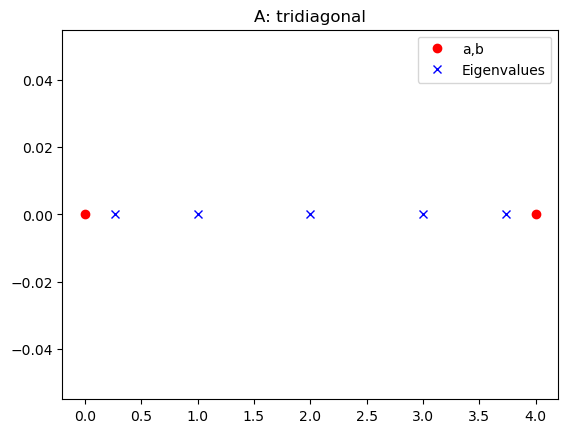

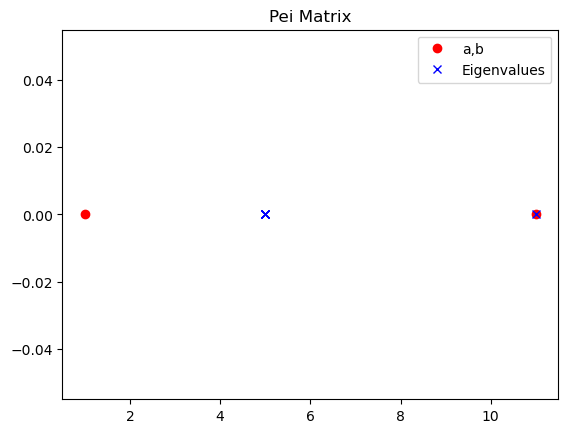

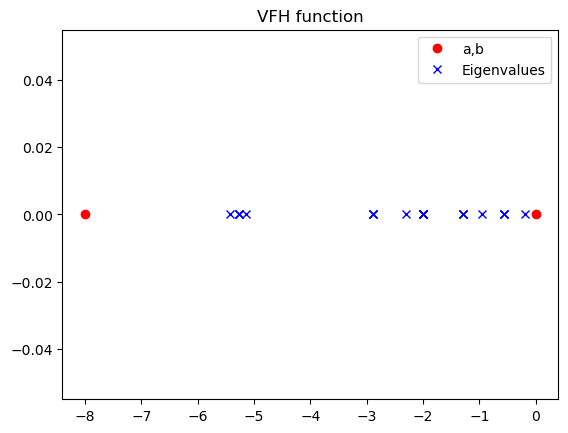

In [90]:
# Test Gerschogorin algo: [a,b] should contain all eigenvalues of A.
A = tridiag(vec1, vec2, vec3)
a, b = Gerschgorin(A)
eig = np.linalg.eigvals(A)
plt.plot([a,b], np.zeros(2), 'ro')
plt.plot(eig, np.zeros(len(eig)), 'bx')
plt.legend(['a,b', 'Eigenvalues'])
plt.title("A: tridiagonal")
plt.show()

# other matrices
A = Pei_function(alpha=5, n=6)
a, b = Gerschgorin(A)
eig = np.linalg.eigvals(A)
plt.plot([a,b], np.zeros(2), 'ro')
plt.plot(eig, np.zeros(len(eig)), 'bx')
plt.title("Pei Matrix")
plt.legend(['a,b', 'Eigenvalues'])
plt.show()

K=2
A = VFH_function(K)
a, b = Gerschgorin(A)
eig = np.linalg.eigvals(A)
plt.plot([a,b], np.zeros(2), 'ro')
plt.plot(eig, np.zeros(len(eig)), 'bx')
plt.title("VFH function")
plt.legend(['a,b', 'Eigenvalues'])
plt.show()

In [91]:
# test T_tilda function: a should become an eigenvalue of T_tilda_j.
a = 1e-3
gamma = 3
A=Pei_function(alpha=5, n=4)
T_tilda_j = T_tilda(A, gamma, a)
print("A=\n", A)
print("A_tilda=\n", T_tilda_j)


eigs = np.linalg.eigvals(T_tilda_j)
in_eigs = False
for i in range(len(eigs)):
    if(np.abs(a-eigs[i])<1e-7):
        in_eigs=True
print("Is 'a' in the eigenvalues of T_tilda_j:", in_eigs) 
print(check_new_eig(a, np.sort(eigs)))

A=
 [[6. 1. 1. 1.]
 [1. 6. 1. 1.]
 [1. 1. 6. 1.]
 [1. 1. 1. 6.]]
A_tilda=
 [[6.         1.         1.         1.         0.        ]
 [1.         6.         1.         1.         0.        ]
 [1.         1.         6.         1.         0.        ]
 [1.         1.         1.         6.         3.        ]
 [0.         0.         0.         3.         1.60129783]]
Is 'a' in the eigenvalues of T_tilda_j: True
True


In [92]:
def algorithm_1_Gauss(A, u, function, maxit=50, epsilon=1e-5):
    # try with another A, check that x_j are orthogonal, check that Gauss works
    '''
    Implements algorithm 1 from Bai et al. It computes a lower/upper bound of the quantity u^T f(A) u by using the Gauss-Radau rules
    INPUT:
    - A: a symmetric positive definite matrix of size n times n for some n, with eigenvalues in [a,b]
    - u: vector of size n 
    - f: smooth function in the interval [a,b]
    - maxit: maximum number of iteration
    - epsilon: tolerance between two iterations
    
    OUTPUT:
    - [U,L]: Upper and Lower bound of the quantity u^T f(A) u by using the Gauss-Radau rule.
    '''
    # Remark 1:
    interval = Gerschgorin(A)
    if interval[0]<=0:
        interval[0] = 1e-4
    print("Inteval [a,b] given by the Gerschgorin algor.:")
    print("a =", interval[0])
    print("b =", interval[1])

    # set the first variables
    x_j2 = 0
    x_j1 = u/np.linalg.norm(u)    
    gamma_j = 0
    I_j = 0
    I_j1 = 0
    X = [x_j1]
    
    for j in range(maxit):
        alpha_j = x_j1.T @ A @ x_j1
        r_j = A @ x_j1 - alpha_j*x_j1 - gamma_j*x_j2
        gamma_j = np.linalg.norm(r_j)

        # build T_j:
        if j==0:
            T_j = np.array([alpha_j])
        else:
            # print("T_j shape:", T_j.shape)
            # horizontal array [0, ..., 0, gamma_j
            temp_h = np.expand_dims(np.zeros(T_j.shape[0]),1)
            temp_h[-1] = gamma_j
            # print("temp h shape:",temp_h.shape)
            # vertical array [0, ..., 0, gamma_j, alpha_j].T
            temp_v = np.expand_dims(np.zeros(T_j.shape[0] + 1),1)
            temp_v[-1] = alpha_j
            temp_v[-2] = gamma_j
            # print("temp v shape:", temp_v.shape)
            # new T_j:
            T_j = np.hstack((np.vstack((T_j, temp_h.T)), temp_v))
        
            # compute eigenvalues of T_tilda_j: HERE LOOK AT REMARK 6: IT COULD BE SIMPLIFIED!!
            theta_k, eig_vec = np.linalg.eig(T_j)
            w_k_square = eig_vec[0, :]*eig_vec[0,:]
            I_j = np.sum(function(theta_k)*w_k_square)


        if j>0 and np.abs(I_j - I_j1) <= epsilon*np.abs(I_j):
            print("Tolerance", epsilon, "was reached at iteration", j+1)
            break

        x_j2 = x_j1
        x_j1 = r_j/gamma_j
        I_j1 = I_j
        X.append(x_j1)
        
    print("check that vectors x_j are orthogonal:", check_ortho(np.array(X)))
    if not check_ortho(np.array(X)):
        warn("The algorithm does not build an orthonormal basis.")
    
    return u.dot(u)*I_j  

In [99]:
def algorithm_1(A, u, function, maxit=50, epsilon=1e-5):
    # try with another A, check that x_j are orthogonal, check that Gauss works
    '''
    Implements algorithm 1 from Bai et al. It computes a lower/upper bound of the quantity u^T f(A) u by using the Gauss-Radau rules
    INPUT:
    - A: a symmetric positive definite matrix of size n times n for some n, with eigenvalues in [a,b]
    - u: vector of size n 
    - f: smooth function in the interval [a,b]
    - maxit: maximum number of iteration
    - epsilon: tolerance between two iterations
    
    OUTPUT:
    - [U,L]: Upper and Lower bound of the quantity u^T f(A) u by using the Gauss-Radau rule.
    '''
    # Remark 1:
    interval = Gerschgorin(A)
    if interval[0]<=0:
        interval[0] = 1e-4
    print("a =", interval[0])
    print("b =", interval[1])
    if (np.linalg.eigvals(A)<=0).any():
        warn("The matrix A should be positive definite.")
        print("eigenvalues of A:", np.linalg.eigvals(A))
    if not (A==A.T).all():
        warn("A is not symmetric. Please choose A such that A=A.T")
        print("A =",A)

    # set the first variables
    x_j2 = np.zeros(u.shape[0])
    x_j1 = u/np.linalg.norm(u)    
    gamma_j = 0.0
    I_j = np.zeros(2)
    I_j1 = np.zeros(2)
    X = [x_j1]

    for j in range(maxit):
        print("START j=", j)
        w = np.dot(A, x_j1)
        alpha_j = np.dot(w, x_j1)
        r_j = w - alpha_j*x_j1 - gamma_j*x_j2
        gamma_j = np.linalg.norm(r_j)

        # build T_j:
        if j==0:
            T_j = np.array([alpha_j])
        else:
            # print("T_j shape:", T_j.shape)
            # horizontal array [0, ..., 0, gamma_j]
            temp_h = np.expand_dims(np.zeros(T_j.shape[0]),1)
            temp_h[-1] = gamma_j
            # print("temp h shape:",temp_h.shape)
            # vertical array [0, ..., 0, gamma_j, alpha_j].T
            temp_v = np.expand_dims(np.zeros(T_j.shape[0] + 1),1)
            temp_v[-1] = alpha_j
            temp_v[-2] = gamma_j
            # print("temp v shape:", temp_v.shape)
            # new T_j:
            T_j = np.hstack((np.vstack((T_j, temp_h.T)), temp_v))
            #print("T_j:", T_j)
        
        # for Gauss Radau, a or b have to be zeros of the polynomial, i.e. must be eigenvalues of T_tilda_j:
        for i in range(2): # for lower and upper bounds
            T_tilda_j = T_tilda(T_j, gamma_j, interval[i])
            #print("T_tilda_j=", T_tilda_j)
            # compute eigenvalues of T_tilda_j: HERE LOOK AT REMARK 6: IT COULD BE SIMPLIFIED!!
            theta_k, eig_vec = np.linalg.eig(T_tilda_j)
            w_k_square = eig_vec[0, :]*eig_vec[0,:]
            I_j[i] = np.sum(function(theta_k)*w_k_square)
            #I_j[i] = np.linalg.inv(T_tilda_j)[0,0]

            if not check_new_eig(interval[i], np.sort(theta_k)):
                warn("The matrix T_tilda_j does not have the right eigenvalues.")
                print("interval[", i, "]=", interval[i])
                print(np.sort(theta_k))

        print("at j=", j,", I_j=", I_j)
        
        if (j>0) & (np.abs(I_j - I_j1) <= epsilon*np.abs(I_j)).any() :
            print("should be all true:")
            print(j>0)
            print(np.abs(I_j[0] - I_j1[0]) <= epsilon*np.abs(I_j[0]))
            print(np.abs(I_j[1] - I_j1[1]) <= epsilon*np.abs(I_j[1]))
            print("Tolerance", epsilon, "was reached at iteration", j+1)
            print("np.abs(I_j-I_j1)=", np.abs(I_j - I_j1))
            print("at j =", j+1, ", I_j=", I_j)
            print("at j =", j+1,", I_j1=", I_j1)
            print("tol*Interval=", epsilon*I_j)
            break

        x_j2 = x_j1.copy()
        x_j1 = r_j/gamma_j
        I_j1 = I_j.copy()

        X.append(x_j1.copy())
        print("check that vectors x_j are orthogonal:", check_ortho(np.array(X).T)) #tranpose here is important
        if not check_ortho(np.array(X).T):
            warn("The algorithm does not build an orthonormal basis, at j ="+str(j))
    
    return u.dot(u)*I_j     
       

In [100]:
def Lanczos(A, u, maxit=50):
    # Remark 1:
    interval = Gerschgorin(A)
    if interval[0]<=0:
        interval[0] = 1e-4
    print("a =", interval[0])
    print("b =", interval[1])
    if (np.linalg.eigvals(A)<=0).any():
        warn("The matrix A should be positive definite.")
        print("eigenvalues of A:", np.linalg.eigvals(A))
    if not (A==A.T).all():
        warn("A is not symmetric. Please choose A such that A=A.T")
        print("A =",A)

    # set the first variables
    x_j1 = u/np.linalg.norm(u)    
    gamma_j = 0.0

    X = [x_j1]

    for j in range(maxit):
        print("START j=", j)
        #print("X[j] =", X[j])
        w = np.dot(A, X[j])
        alpha_j = np.dot(w, X[j])
        r_j = w - alpha_j*x_j1
        if j>0:
            r_j = r_j - gamma_j*X[j-1]
        #    print("X[j-1] =", X[j-1])
        #print("r_j =", r_j)
        

        gamma_j = np.linalg.norm(r_j)
        x_j1 = r_j/gamma_j

        X.append(x_j1.copy())
        print("check that vectors x_j are orthogonal:", check_ortho(np.array(X).T))
        if not check_ortho(np.array(X).T):
            warn("The algorithm does not build an orthonormal basis.")
            print("X =", np.array(X).T)

    if not check_ortho(np.array(X).T):
        warn("The algorithm does not build an orthonormal basis.")
        print("X =", np.array(X).T)
    
    return np.array(X).T

In [101]:
n=29
A=Pei_function(alpha=5, n=n)
u = np.zeros(n)
u[-1] = 1
u[0] = 1
u = np.random.rand(n)
maxit = n-2
X = Lanczos(A, u, maxit)
print(X)

a = 0.0001
b = 34.0
START j= 0
check that vectors x_j are orthogonal: True
START j= 1
check that vectors x_j are orthogonal: False
X = [[ 0.16647699  0.08593259 -0.0884042 ]
 [ 0.06721442  0.22813593  0.0884042 ]
 [ 0.21706125  0.01346568 -0.2652126 ]
 [ 0.00615135  0.31561476  0.29836417]
 [ 0.23053829 -0.00584149 -0.0884042 ]
 [ 0.25933432 -0.04709463 -0.1768084 ]
 [ 0.21483647  0.01665291 -0.0884042 ]
 [ 0.33825526 -0.16015659 -0.3536168 ]
 [ 0.14076526  0.12276716  0.0884042 ]
 [ 0.05389168  0.24722206  0.        ]
 [ 0.32414877 -0.13994767 -0.1768084 ]
 [ 0.21135754  0.02163682 -0.0884042 ]
 [ 0.01175177  0.3075916   0.03315157]
 [ 0.0983335   0.18355481  0.1326063 ]
 [ 0.19391511  0.04662479 -0.1768084 ]
 [ 0.12476872  0.14568376 -0.0884042 ]
 [ 0.30822907 -0.11714114 -0.1768084 ]
 [ 0.06733761  0.22795945  0.06630315]
 [ 0.21550081  0.01570116 -0.1768084 ]
 [ 0.00692545  0.31450578  0.38676837]
 [ 0.03554504  0.27350542  0.01105052]
 [ 0.04489767  0.26010687  0.0884042 ]
 [ 0.16

C:\Users\anyam\AppData\Local\Temp/ipykernel_50696/1626677097.py:39: UserWarning: The algorithm does not build an orthonormal basis.
  warn("The algorithm does not build an orthonormal basis.")
C:\Users\anyam\AppData\Local\Temp/ipykernel_50696/1626677097.py:43: UserWarning: The algorithm does not build an orthonormal basis.
  warn("The algorithm does not build an orthonormal basis.")


In [102]:
k=9
A= Poisson_function(k=k)
n=k**2
u = np.zeros(n)
u[0] = 1
#u = np.random.rand(n)
maxit = 20
X = Lanczos(A, u, maxit)

a = 0.0001
b = 8.0
START j= 0
check that vectors x_j are orthogonal: True
START j= 1
check that vectors x_j are orthogonal: True
START j= 2
check that vectors x_j are orthogonal: True
START j= 3
check that vectors x_j are orthogonal: True
START j= 4
check that vectors x_j are orthogonal: True
START j= 5
check that vectors x_j are orthogonal: True
START j= 6
check that vectors x_j are orthogonal: True
START j= 7
check that vectors x_j are orthogonal: True
START j= 8
check that vectors x_j are orthogonal: True
START j= 9
check that vectors x_j are orthogonal: True
START j= 10
check that vectors x_j are orthogonal: True
START j= 11
check that vectors x_j are orthogonal: True
START j= 12
check that vectors x_j are orthogonal: True
START j= 13
check that vectors x_j are orthogonal: True
START j= 14
check that vectors x_j are orthogonal: True
START j= 15
check that vectors x_j are orthogonal: True
START j= 16
check that vectors x_j are orthogonal: True
START j= 17
check that vectors x_j are 

In [107]:
#the Pei matrix
k=12
A= Poisson_function(k=k)
n=k**2
print("n=",n)
u = np.zeros(n)
u[0] = 1
u = np.random.randn(n)
def f(x):
    return 1/x
tol = 1e-2
L = algorithm_1(A=A, u=u, function=f, maxit=200, epsilon=tol)

print("bounds", L)

# exact value of u^T f(A) u:
I_ex = u.dot(np.linalg.inv(A).dot(u))
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("L<I_ex:", L[1]<I_ex )
print("U>I_ex:", L[0]>I_ex )

n= 144
a = 0.0001
b = 8.0
START j= 0
at j= 0 , I_j= [2.04154901e+03 3.03124838e-01]
check that vectors x_j are orthogonal: True
START j= 1
at j= 1 , I_j= [9.97048627e+02 4.05645170e-01]
check that vectors x_j are orthogonal: True
START j= 2
at j= 2 , I_j= [356.22764114   0.43040776]
check that vectors x_j are orthogonal: True
START j= 3
at j= 3 , I_j= [245.7479422    0.46781071]
check that vectors x_j are orthogonal: True
START j= 4
at j= 4 , I_j= [200.01831624   0.51665575]
check that vectors x_j are orthogonal: True
START j= 5
at j= 5 , I_j= [146.02301631   0.54171093]
check that vectors x_j are orthogonal: True
START j= 6
at j= 6 , I_j= [112.19051935   0.56666915]
check that vectors x_j are orthogonal: True
START j= 7
at j= 7 , I_j= [72.98196407  0.57741132]
check that vectors x_j are orthogonal: True
START j= 8
at j= 8 , I_j= [45.65953008  0.58449047]
check that vectors x_j are orthogonal: True
START j= 9
at j= 9 , I_j= [24.26404518  0.58738616]
should be all true:
True
False
True


In [108]:
#the Pei matrix
n=120
A=Pei_function(alpha=5, n=n)
def f(x):
    return 1/x
u = np.zeros(n)
u[1] = 1
u = np.random.randn(n)
tol = 1e-2
L = algorithm_1(A=A, u=u, function=f, maxit=200, epsilon=tol)

print("lower bound L=", L)

# exact value of u^T f(A) u:
I_ex = u.dot(np.linalg.inv(A).dot(u))
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("L<I_ex:", L[1]<I_ex )
print("U>I_ex:", L[0]>I_ex )

a = 0.0001
b = 125.0
START j= 0
at j= 0 , I_j= [8.21236976e+03 1.97130096e-01]
check that vectors x_j are orthogonal: True
START j= 1
at j= 1 , I_j= [0.14719541 0.14719541]
check that vectors x_j are orthogonal: False
START j= 2
at j= 2 , I_j= [0.14719541 0.14719541]
should be all true:
True
True
True
Tolerance 0.01 was reached at iteration 3
np.abs(I_j-I_j1)= [0. 0.]
at j = 3 , I_j= [0.14719541 0.14719541]
at j = 3 , I_j1= [0.14719541 0.14719541]
tol*Interval= [0.00147195 0.00147195]
lower bound L= [16.31693267 16.31693267]
exact value: 21.852302166106043
L<I_ex: True
U>I_ex: False


C:\Users\anyam\AppData\Local\Temp/ipykernel_50696/3584925545.py:97: UserWarning: The algorithm does not build an orthonormal basis, at j =1
  warn("The algorithm does not build an orthonormal basis, at j ="+str(j))


In [66]:
u_A = np.random.randn(n_A)
L = algorithm_1_Gauss(A=A, u=u_A, function=f, maxit=200, epsilon=tol)

print("lower bound L=", L)

# exact value of u^T f(A) u:
I_ex = u_A.dot(np.linalg.inv(A).dot(u_A))
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("is the exact value bellow L:", L<I_ex )

Inteval [a,b] given by the Gerschgorin algor.:
a = 0.0001
b = 125.0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 120 is different from 5)

In [81]:
tol = 1e-18
maxit = 2
u_A = np.random.rand(n_A)

def f(x):
    return 1/x

def id(x):
    return x

U, L = algorithm_1(A=A, u=u_A, function=f, maxit=200, epsilon=tol)
print("L=", L)
print("U=", U)

# exact value of u^T f(A) u:
I_ex = u_A.dot(np.linalg.inv(A)@u_A)
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("is the exact value between L and U:", I_ex<U and L<I_ex)

a = 0.0001
b = 4.0
I_j: [6.27955425e+03 2.25373842e+00]
T_j: [[0.60601772 0.61726071]
 [0.61726071 2.28409227]]
I_j: [1126.27192467    2.31766745]
should be all true:
True
True
True
Tolerance 1e-18 was reached at iteration 2
np.abs(I_j[0]-I_j1[])= 0.0
tol*Interval[0]= 1.1262719246693463e-15
tol*Interval[1]= 2.31766745239874e-18
check that vectors x_j are orthogonal: True
L= 3.5601289466160995
U= 1730.046852332691
exact value: 4.886704930317286
is the exact value between L and U: True


### e) Numerical experiments (first draft)

In [6]:
import time 
import numpy as np
from scipy.linalg import block_diag

In [7]:
#cell to be rewritten, temporary assignement to A
A=np.eye(3,3) 

**The different matrices they experimented on in the paper:**

In [8]:
#example 1: the heat flow matrix

In [2]:
n=2
nu=3 #some random values for now, nu>0 implies heat_flow_matrix is positive definite which is something we want
heat_flow_matrix=heat_flow_function(nu,n)
heat_flow_matrix

array([[13., -3., -3.,  0.],
       [-3., 13.,  0., -3.],
       [-3.,  0., 13., -3.],
       [ 0., -3., -3., 13.]])

In [17]:
#the Pei matrix
alpha=2
n=4
Pei_matrix=Pei_function(alpha, n)

u = np.random.rand(n)
U, L = algorithm_1(A=Pei_matrix, u=u, function=f, maxit=200, epsilon=tol)
print("L=", L)
print("U=", U)

# exact value of u^T f(A) u:
I_ex = u.dot(np.linalg.inv(Pei_matrix)@u)
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("is the exact value between L and U:", I_ex<U and L<I_ex)

a = 0.0001
b = 6.0
Tolerance 1e-13 was reached at iteration 2
L= 0.16153600220772452
U= 0.16153600220772452
exact value: 0.19887453815178047
is the exact value between L and U: False


In [ ]:
#running time of algo 2

start=time.time()
E,L,U=algorithm_2(A,m,p) #for some m,p to tune 
execution_algo_2=time.time()-start 

In [4]:
#running time using built in numpy functions
A=heat_flow_matrix
start=time.time()
Tr_A_inv=np.trace(np.linalg.inv(A))
execution_built_in=time.time()-start 
print('execution time', execution_built_in)

execution time 0.0012359619140625


In [6]:
#solving n linear equations

#(Armelle: in my opinion, when they say compute trace(inv(A)) using n linear equations, they mean computing 
#e_i.T inv(A) e_i for i in {1,...,n} )

start=time.time()
n=A.shape[0]

trace=0
for i in range(n):
    e=np.zeros(n)
    e[i]=1
    trace+=e.T@np.linalg.inv(A)@e
execution_linear_equations=time.time()-start 

print('execution time', execution_linear_equations)

execution time 0.03495073318481445


In [ ]:
#using algorithm 1

n=A.shape[0]
start=time.time()
trace=0
for i in range (n):
    trace+= #output of algo 1 (I guess here also parameter values to tune)
execution_algo_1=time.time()-start 